<a href="https://colab.research.google.com/github/Shubhankitsirvaiya/Appliance-Energy-Prediction/blob/main/Capstone_Project_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data-driven prediction of energy use of appliances
The data set is at 10 min for about 4.5 months. The house temperature and humidity conditions
were monitored with a ZigBee wireless sensor network. Each wireless node transmitted the
temperature and humidity conditions around 3.3 min. Then, the wireless data was averaged for
10 minutes periods. The energy data was logged every 10 minutes with m-bus energy meters.
Weather from the nearest airport weather station (Chievres Airport, Belgium) was downloaded
from a public data set from Reliable Prognosis (rp5.ru) and merged together with the
experimental data sets using the date and time column. Two random variables have been
included in the data set for testing the regression models and to filter out non-predictive attributes
(parameters).

date time year-month-day hour:minute:second
Appliances, energy use in Wh (Dependent variable)
lights, energy use of light fixtures in the house in Wh (Drop this column)
T1, Temperature in kitchen area, in Celsius
RH1, Humidity in kitchen area, in % 
T2, Temperature in living room area, in Celsius RH2,
Humidity in living room area, in %
T3, Temperature in laundry room area
RH3, Humidity in laundry room area, in % T4, Temperature in office room, in Celsius RH4,
Humidity in office room, in %
T5, Temperature in bathroom, in Celsius
RH5, Humidity in bathroom, in % T6, Temperature outside the building (north side), in Celsius
RH6, Humidity outside the building (north side), in %
T7, Temperature in ironing room , in Celsius
RH7, Humidity in ironing room, in % T8, Temperature in teenager room 2, in Celsius RH8,
Humidity in teenager room 2, in %
T9, Temperature in parents room, in Celsius
RH9, Humidity in parents room, in % To, Temperature outside (from Chievres weather station), in
Celsius Pressure (from Chievres weather station), in mm Hg RHout, Humidity outside (from
Chievres weather station), in %
Wind speed (from Chievres weather station), in m/s
Visibility (from Chievres weather station), in km
Tdewpoint (from Chievres weather station), Â°C
rv1, Random variable 1, nondimensional
rv2, Random variable 2, nondimensional

Where indicated, hourly data (then interpolated) from the nearest airport weather station
(Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis,
rp5.ru. Permission was obtained from Reliable Prognosis for the distribution of the 4.5 months of
weather data.

#Importing Libraries

In [282]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

%matplotlib inline

#Getting the Data

In [78]:
df=pd.read_csv('/content/drive/MyDrive/Copy of data_application_energy.csv')
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


#Data X ray

In [79]:
df.tail()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
19730,2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.7,45.590000,23.20,52.400000,24.796667,1.0,24.500000,44.500000,24.7000,50.07400,23.2,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812
19731,2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.7,45.590000,23.23,52.326667,24.196667,1.0,24.557143,44.414286,24.7000,49.79000,23.2,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940
19732,2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.7,45.730000,23.23,52.266667,23.626667,1.0,24.540000,44.400000,24.7000,49.66000,23.2,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117
19733,2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.7,45.790000,23.20,52.200000,22.433333,1.0,24.500000,44.295714,24.6625,49.51875,23.2,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784
19734,2016-05-27 18:00:00,430,10,25.500000,46.600000,25.264286,42.971429,26.823333,41.156667,24.7,45.963333,23.20,52.200000,21.026667,1.0,24.500000,44.054000,24.7360,49.73600,23.2,46.8450,22.200000,755.2,57.000000,4.000000,27.000000,13.200000,34.118851,34.118851


In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9  

In [81]:
df.describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,97.694958,3.801875,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,19.592106,50.949283,7.910939,54.609083,20.267106,35.388200,22.029107,42.936165,19.485828,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707,24.988033,24.988033
std,102.524891,7.935988,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,1.844623,9.022034,6.090347,31.149806,2.109993,5.114208,1.956162,5.224361,2.014712,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648,14.496634,14.496634
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,15.330000,29.815000,-6.065000,1.000000,15.390000,23.200000,16.306667,29.600000,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322
25%,50.000000,0.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,18.277500,45.400000,3.626667,30.025000,18.700000,31.500000,20.790000,39.066667,18.000000,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889
50%,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,19.390000,49.090000,7.300000,55.290000,20.033333,34.863333,22.100000,42.375000,19.390000,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333,24.897653,24.897653
75%,100.000000,0.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,20.619643,53.663333,11.256000,83.226667,21.600000,39.000000,23.390000,46.536000,20.600000,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667,37.583769,37.583769
max,1080.000000,70.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,25.795000,96.321667,28.290000,99.900000,26.000000,51.400000,27.230000,58.780000,24.500000,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530


##Checking for null values

In [215]:
df.isna().sum()

date           0
Appliances     0
lights         0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
rv1            0
rv2            0
hour           0
weekday        0
avg_temp       0
avg_hum        0
dtype: int64

#EDA

###Target Variable Distribution

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


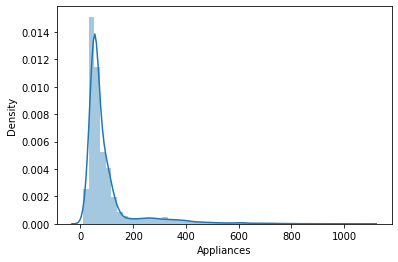

In [82]:
sns.distplot(df['Appliances'])

In [221]:
df.columns

Index(['date', 'Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3',
       'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8',
       'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
       'Visibility', 'Tdewpoint', 'rv1', 'rv2', 'hour', 'weekday', 'avg_temp',
       'avg_hum'],
      dtype='object')

##UniVariate Analysis

In [222]:
temp_col=['T1','T2','T3','T4','T5','T6','T7','T8','T9']
hum_col=['RH_1','RH_2','RH_3','RH_4','RH_5','RH_6','RH_7','RH_8','RH_9']
other_col=['T_out', 'Press_mm_hg', 'RH_out', 'Windspeed','Visibility', 'Tdewpoint', 'rv1', 'rv2']

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

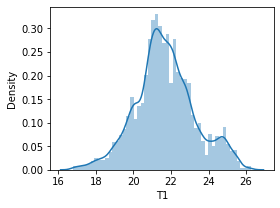

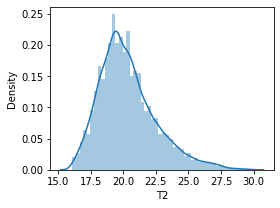

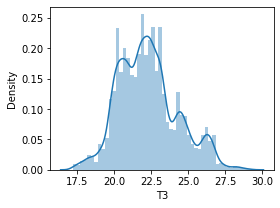

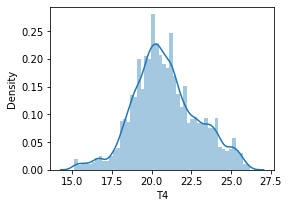

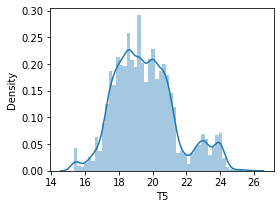

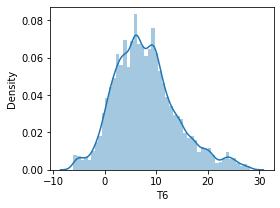

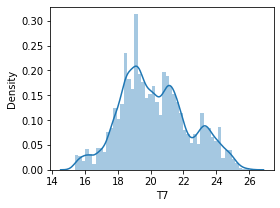

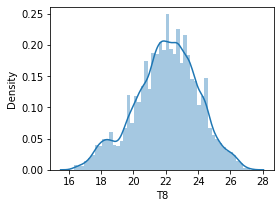

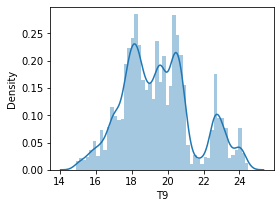

In [219]:
for i in temp_col:
  plt.figure(figsize=(4,3))
  sns.distplot(df[i])

there are no , outliers otherwise we would have seen skewness in the in the Temp data.
Mostly they follow a bell curve

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

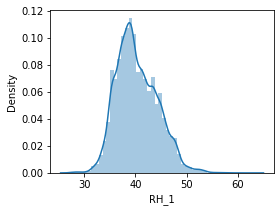

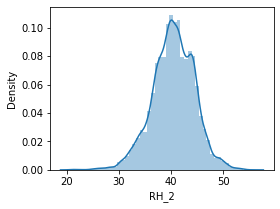

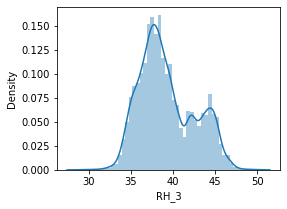

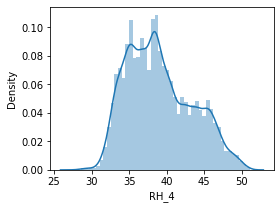

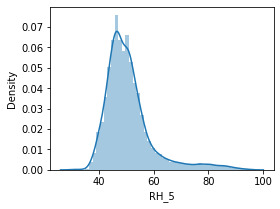

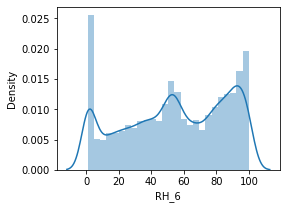

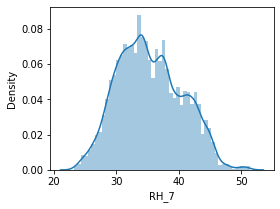

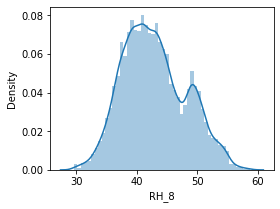

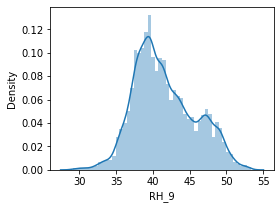

In [220]:
for i in hum_col:
  plt.figure(figsize=(4,3))
  sns.distplot(df[i])

There are not outliers , but we will have to check as all variable here in Relative humidity does not have Bell curve distribution

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

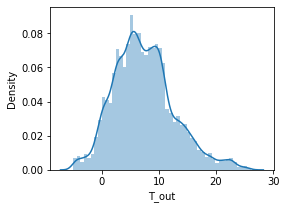

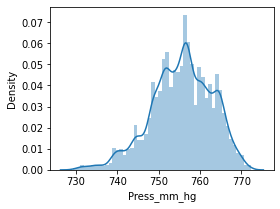

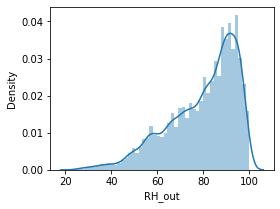

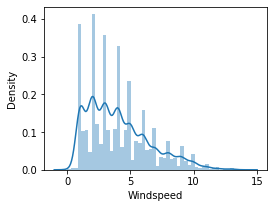

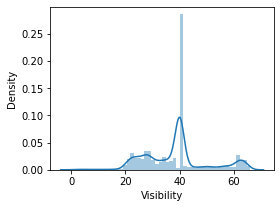

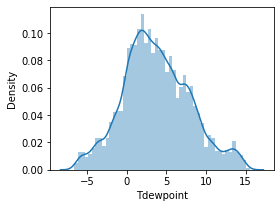

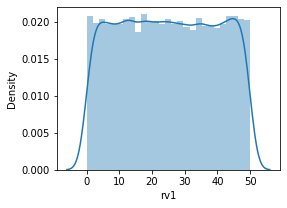

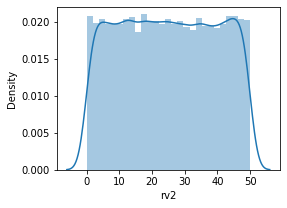

In [223]:
for i in other_col:
  plt.figure(figsize=(4,3))
  sns.distplot(df[i])

Distribution of other varibles also dont have bell curve distribution, we may have to use Transformations on it if we use in the final model

##Bivariate Analysis

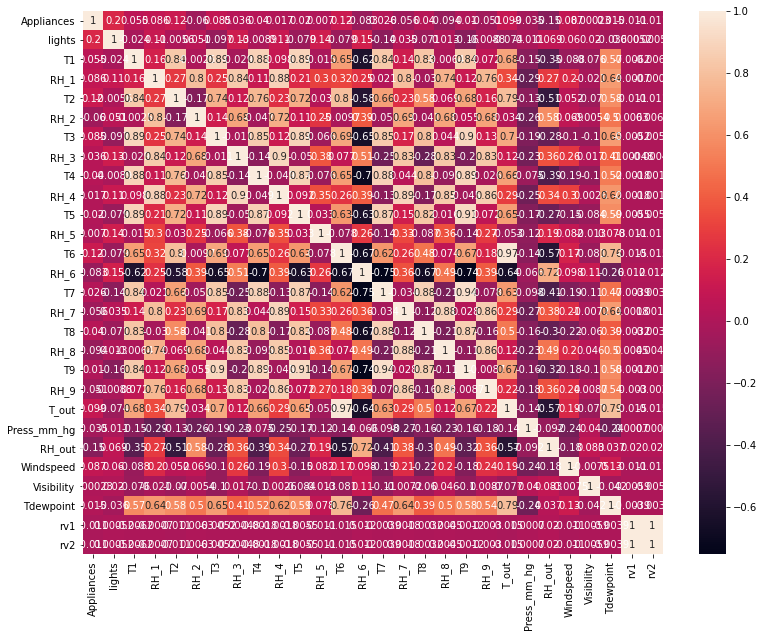

In [85]:
plt.figure(figsize=(13,10))
sns.heatmap(df.corr(),annot=True,)

we can create the columnns for weekday and hour of day , to look for hourwise and Weekay wise analysis

In [224]:
import datetime 
def hour_fet(x):
   return pd.to_datetime(x).hour

def weekday_fet(x):
   return pd.to_datetime(x).weekday()
   
df['hour']=df['date'].apply(hour_fet)
df['weekday']=df['date'].apply(weekday_fet)

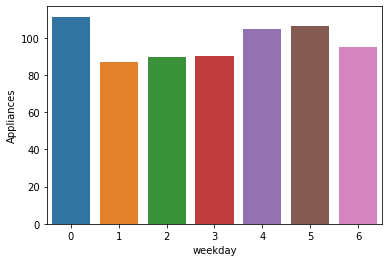

In [92]:
weekday_eng=pd.DataFrame(df.groupby('weekday')['Appliances'].mean()).reset_index()
sns.barplot(x=weekday_eng['weekday'],y=weekday_eng['Appliances'])

Here we see that , that consumption is higher on weekends , ie week number 0, 6, 5

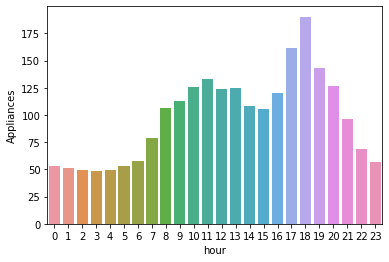

In [93]:
hour_eng=pd.DataFrame(df.groupby('hour')['Appliances'].mean()).reset_index()
sns.barplot(x=hour_eng['hour'],y=hour_eng['Appliances'])

Here we see that the coonsumption is high in the evening time , ie hour between 16 and 20 

Next we can create average , temp and avg hum for indoor humidity and temperature

In [95]:
df['avg_temp']=0
for i in temp_col:
  df['avg_temp']=df['avg_temp']+df[i]
df['avg_temp']=df['avg_temp']/len(temp_col)

df['avg_hum']=0
for i in hum_col:
  df['avg_hum']=df['avg_hum']+df[i]
df['avg_hum']=df['avg_hum']/len(hum_col)



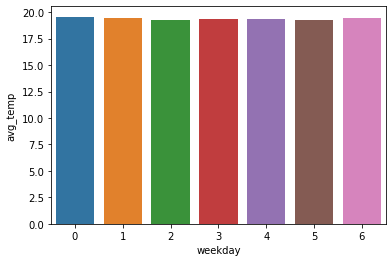

In [225]:
weekday_temp=pd.DataFrame(df.groupby('weekday')['avg_temp'].mean()).reset_index()
sns.barplot(x=weekday_temp['weekday'],y=weekday_temp['avg_temp'])

this shows that the avg indoor temperature does not change with the week 

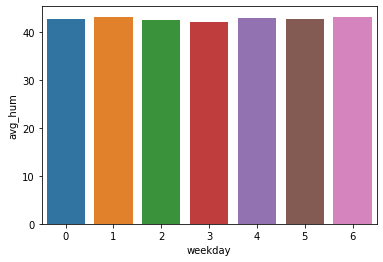

In [98]:
weekday_hum=pd.DataFrame(df.groupby('weekday')['avg_hum'].mean()).reset_index()
sns.barplot(x=weekday_hum['weekday'],y=weekday_hum['avg_hum'])

this shows that the avg indoor Humidity does not change with the week 

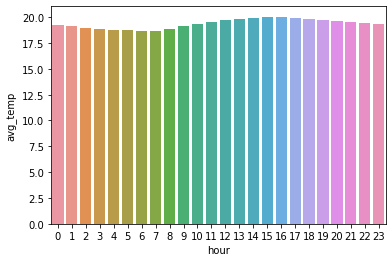

In [99]:
hour_temp=pd.DataFrame(df.groupby('hour')['avg_temp'].mean()).reset_index()
sns.barplot(x=hour_temp['hour'],y=hour_temp['avg_temp'])

this shows that the avg indoor temperature does not change much with the hour in day. Although we have seen that temperature of specific room might be varying.

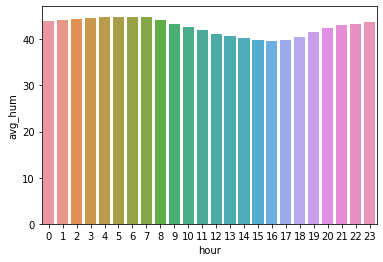

In [100]:
hour_hum=pd.DataFrame(df.groupby('hour')['avg_hum'].mean()).reset_index()
sns.barplot(x=hour_hum['hour'],y=hour_hum['avg_hum'])

this shows that the avg indoor humidity does not change much with the hour in day. Although we have seen that Humidity of specific room might be varying.

All over we can say, the idea of average temp and average humidity might not give any significant results

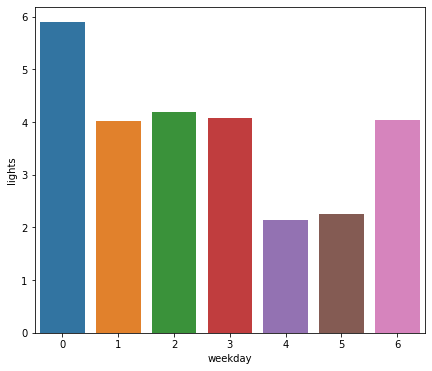

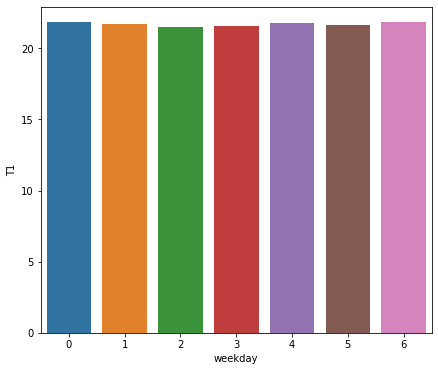

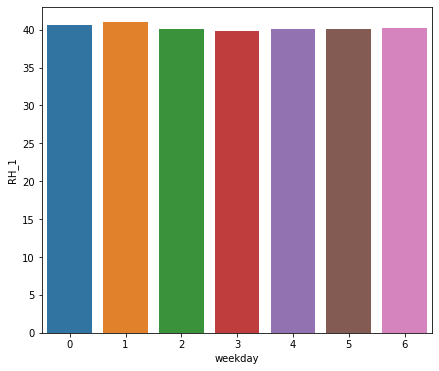

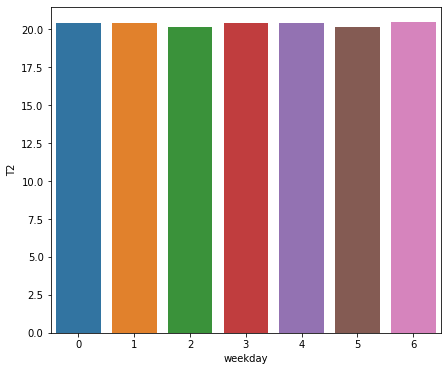

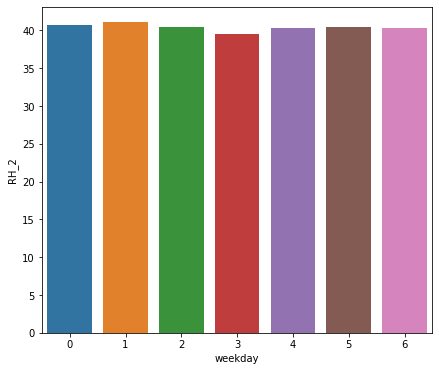

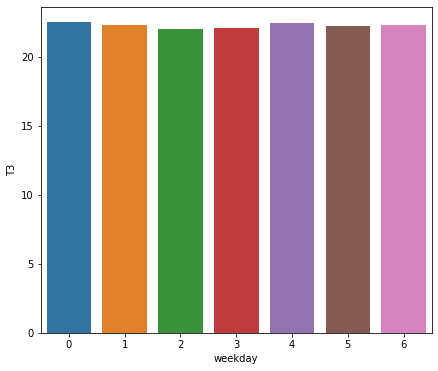

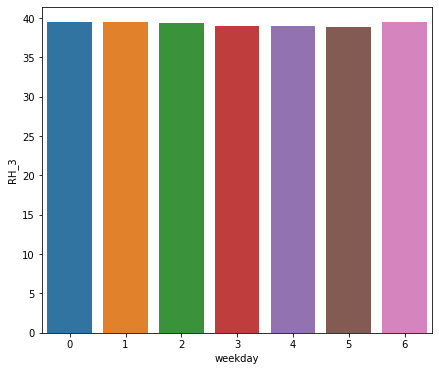

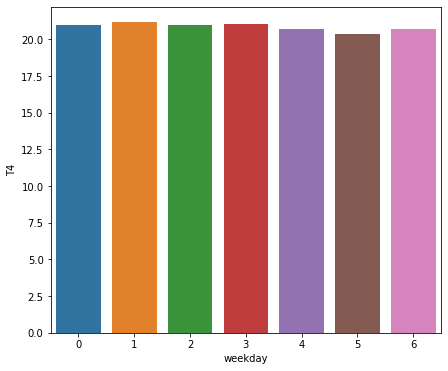

In [101]:
for i in df.columns[2:10]:
  plt.figure(figsize=(7,6))
  df_week=pd.DataFrame(df.groupby('weekday')[i].mean()).reset_index()
  sns.barplot(x=df_week['weekday'],y=df_week[i])

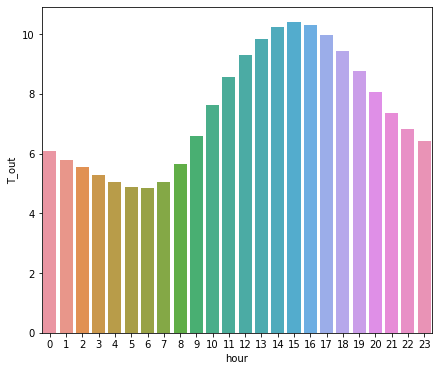

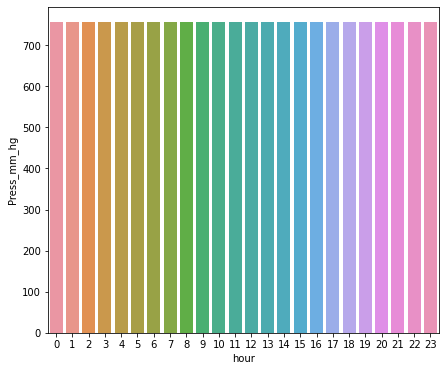

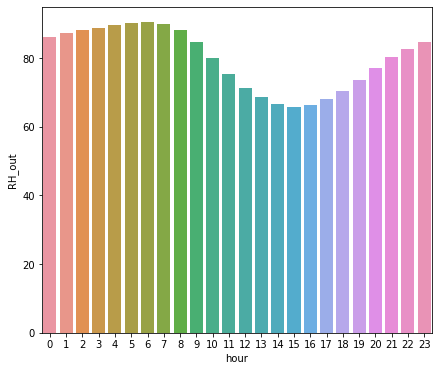

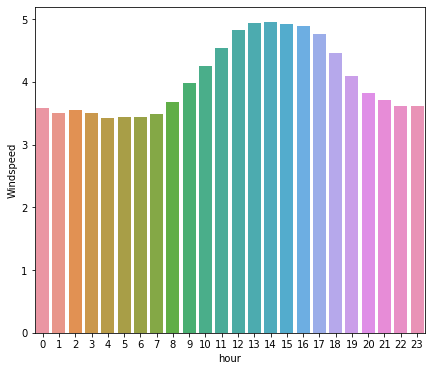

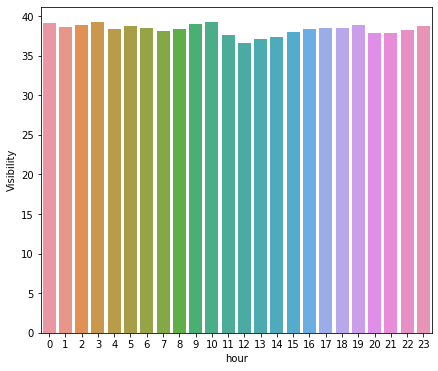

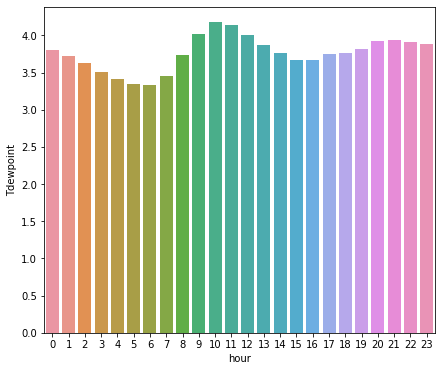

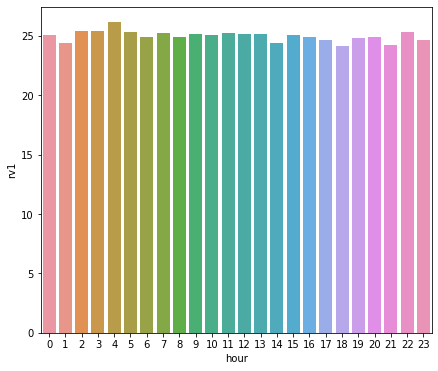

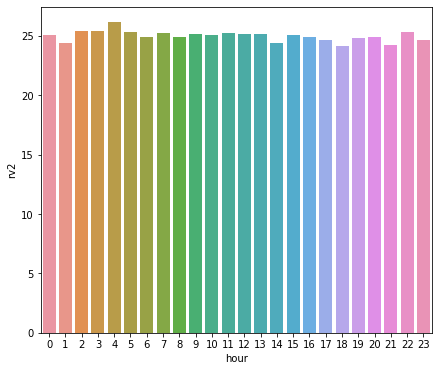

In [226]:
for i in other_col:
  plt.figure(figsize=(7,6))
  df_hour=pd.DataFrame(df.groupby('hour')[i].mean()).reset_index()
  sns.barplot(x=df_hour['hour'],y=df_hour[i])

from here we can say that outside temp and humidity varies very much accross hour , which is expected. 
Same for windspeed, and tdewpoint.

In [227]:
#lets create features based on consumption level.
# is for a particular 10 mins the enerygy consumption is far greater than hour avg then it will be high consumtion or else
'''def consump_level(x):
  if x>25:
    return 'high consump'
  elif x<(-25):
    return 'low consump'

df_1=df.join(hour_eng,on='hour',rsuffix='_all')
df_1['hourly_diff']=df_1['Appliances']-df_1['Appliances_all']
df_1['level']=df_1['hourly_diff'].apply(consump_level)'''

#Although this way we can make a very related variable , but it does not make sense , creating a varibale totally based on target varibale

"def consump_level(x):\n  if x>25:\n    return 'high consump'\n  elif x<(-25):\n    return 'low consump'\n\ndf_1=df.join(hour_eng,on='hour',rsuffix='_all')\ndf_1['hourly_diff']=df_1['Appliances']-df_1['Appliances_all']\ndf_1['level']=df_1['hourly_diff'].apply(consump_level)"

##MultiVariate Analysis

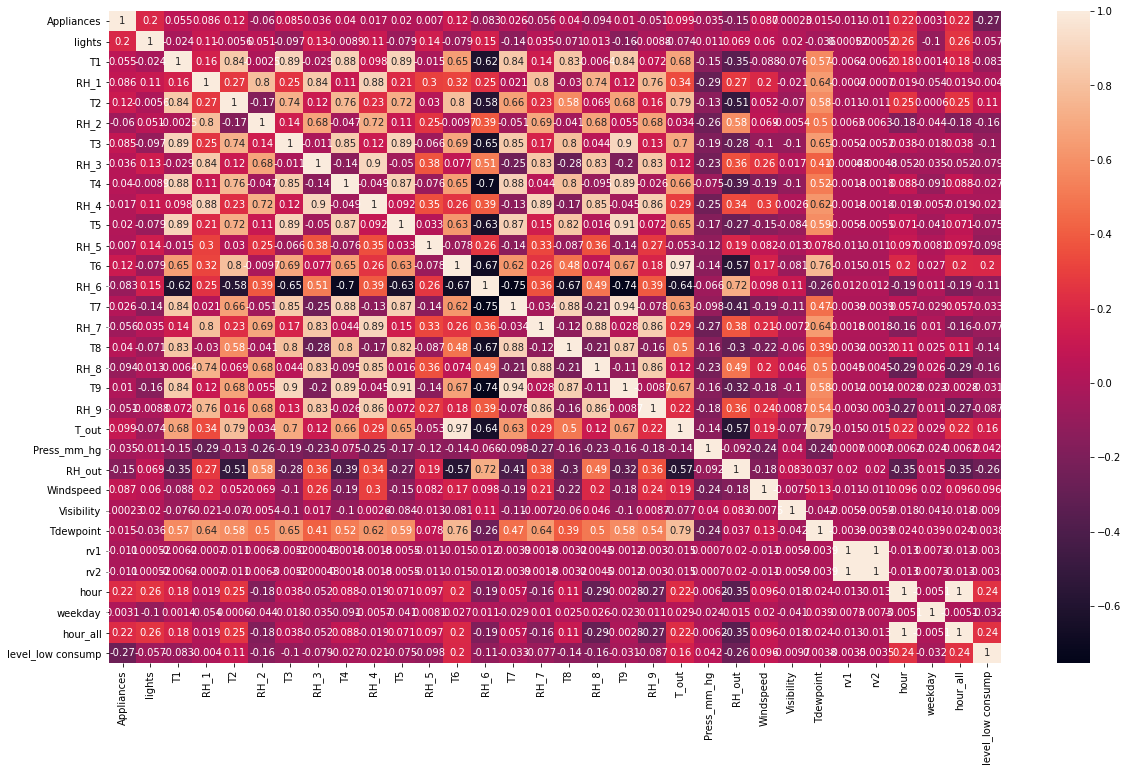

In [228]:
plt.figure(figsize=(20,12))
sns.heatmap(df_1.corr(),annot=True)

from here we see a particular square region as highly correlated , as they are different temperature of same house ,and humidity of same house

In [238]:
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,hour,weekday,avg_temp,avg_hum
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,17,0,17.167407,50.910741
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,17,0,17.149630,50.827222
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,17,0,17.103704,50.628889
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389,17,0,17.067037,50.574815
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097,17,0,17.070741,50.732963


In [254]:
App_corr=[]
for i in df.columns[1:]:
  
  App_corr.append([i,df[['Appliances',i]].corr().iloc[1][0]])

App_corr=pd.DataFrame(App_corr,columns=['feature','correlation']).sort_values(['correlation'],ascending=False)


This way we can get the features which are most correlated with our target variable

#Preparing the Data

In [261]:

X=df[['T1','T4','T3','T6','T2','lights','T_out','Windspeed','RH_1','avg_temp']]
y=df['Appliances']

#Fitting the Model

##Fittng Models without Hyper Parameter tuning or CV

In [269]:
def simple_model(Model):

#spliting the Data into training and test

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
  
#scaling the data

  scaler=StandardScaler()
  X_train=scaler.fit_transform(X_train)
  X_test=scaler.transform(X_test)

#Fitting the model

  model=Model()
  model.fit(X_train,y_train)

#evaluation with Root mean square error and R2 score

  y_train_pred=model.predict(X_train)
  y_pred=model.predict(X_test)
  train_err=np.sqrt(mean_squared_error(y_train_pred,y_train))
  test_err=np.sqrt(mean_squared_error(y_pred,y_test)) 

  train_r2=r2_score(y_train_pred,y_train)
  test_r2=r2_score(y_pred,y_test)

  df_res=pd.DataFrame({'Train Error':train_err,'Test Error':test_err,'train r2':train_r2,'test r2':test_r2},index=[1])
  
  
  '''features = X.columns
  importances = model.feature_importances_
  indices = np.argsort(importances)

  plt.figure(figsize=(10,10))
  plt.title('Feature Importance')
  plt.barh(range(len(indices)), importances[indices], color='red', align='center')
  plt.yticks(range(len(indices)), [features[i] for i in indices])
  plt.xlabel('Relative Importance')'''

  return df_res



In [263]:
simple_model(LinearRegression)

,Train Error,Test Error,train r2,test r2
1,97.31735,100.868243,-9.304038,-10.25796


In [264]:
simple_model(RandomForestRegressor)

,Train Error,Test Error,train r2,test r2
1,27.519086,75.477147,0.890898,-0.23298


In [265]:
simple_model(GradientBoostingRegressor)

,Train Error,Test Error,train r2,test r2
1,87.324988,94.563887,-4.226331,-5.205221


In [266]:
simple_model(Ridge)

,Train Error,Test Error,train r2,test r2
1,97.317353,100.867423,-9.311752,-10.266005


In [267]:
simple_model(SVR)

,Train Error,Test Error,train r2,test r2
1,102.190668,105.864204,-40.189257,-41.651999


In [268]:
simple_model(XGBRegressor)

[17:22:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,Train Error,Test Error,train r2,test r2
1,87.816916,95.114594,-4.416752,-5.458629


##Fittng Models with Hyper Parameter tuning and CV

In [284]:
def tuned_model(Model,params):

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
  scaler=StandardScaler()
  X_train=scaler.fit_transform(X_train)
  X_test=scaler.transform(X_test)

  model=Model()
  grid=GridSearchCV(model,params,scoring='neg_mean_squared_error',cv=3)

  grid.fit(X_train,y_train)

  y_train_pred=grid.predict(X_train)
  y_pred=grid.predict(X_test)
  train_err=np.sqrt(mean_squared_error(y_train_pred,y_train))
  test_err=np.sqrt(mean_squared_error(y_pred,y_test)) 

  train_r2=r2_score(y_train_pred,y_train)
  test_r2=r2_score(y_pred,y_test)

  df_res=pd.DataFrame({'Train Error':train_err,'Test Error':test_err,'train r2':train_r2,'test r2':test_r2},index=[1])

  return df_res

In [285]:
param_dict_rf = {
    'max_depth': [4, 6, 8],
    'min_samples_leaf': [40, 50],
    'min_samples_split': [50, 100, 150],
    'n_estimators': [50,80, 100],
  }
tuned_model(RandomForestRegressor,param_dict_rf)

,Train Error,Test Error,train r2,test r2
1,88.108297,91.654589,-4.287663,-4.690193
